In [32]:
import pandas as pd
import requests
import numpy as np
from bs4 import BeautifulSoup

In [33]:
url = "https://www.fis-ski.com/DB/general/athlete-biography.html?sectorcode=JP&seasoncode=&competitorid=73228&type=result&categorycode=&sort=&place=&disciplinecode=&position=&limit=1000"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
}

response = requests.get(url, headers=headers)
print(response.status_code)
soup = BeautifulSoup(response.content)

200


In [34]:
rows = []

for row in soup.find_all("a", class_="table-row"):

    cols = row.find("div", class_="container").find_all("div", recursive=False)

    date = cols[0].text.strip()
    city = cols[1].text.strip()
    competition = cols[5].text.strip()
    hill = cols[6].text.strip()
    result = cols[-1].text.strip()

    event_row = [date, city, competition, hill, result]
    rows.append(event_row)

df = pd.DataFrame(rows, columns=["Data", "Miasto", "Zawody", "Skocznia", "Wynik"])


# preprocessing

In [35]:
df.head()

,Data,Miasto,Zawody,Skocznia,Wynik
0,14-02-2026,Milano Cortina,Olympic Winter Games,Large Hill HS141,21
1,09-02-2026,Milano Cortina,Olympic Winter Games,Normal Hill HS107,38
2,25-01-2026,Oberstdorf,FIS Ski-Flying World Championships,Team Flying Hill HS235,8
3,23-01-2026,Oberstdorf,FIS Ski-Flying World Championships,Flying Hill HS235,34
4,22-01-2026,Oberstdorf,Qualification,Flying Hill HS235,37


In [36]:
df['Data'] = pd.to_datetime(df['Data'])

df['HS'] = df['Skocznia'].str.extract(r"[HS](\d+)", expand=False).astype(int)
df['Skocznia'] = df['Skocznia'].str.replace(r'\s*HS\d+', '', regex=True).str.strip()

df['Kategoria'] = np.where(df['Skocznia'].str.contains('Team', case=False, na=False),
    'drużynowe', 'indywidualne')

mapa = {'DSQ': -1, 'DNF': -2, 'DNS': -3}
df['Wynik'] = df['Wynik'].replace(mapa).astype(int)

/tmp/ipython-input-1409480383.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Data'] = pd.to_datetime(df['Data'])


In [37]:
df['temp'] = df['Skocznia']
conditions = [
    df['temp'].str.contains('Large', case=False, na=False),
    df['temp'].str.contains('Normal', case=False, na=False)
]

choices = [
    'Duza',
    'Normalna'
]

df['Skocznia'] = np.select(conditions, choices, default='Mamucia')

In [38]:
df= df.drop(columns=['temp', 'Zawody'])

# Analiza

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

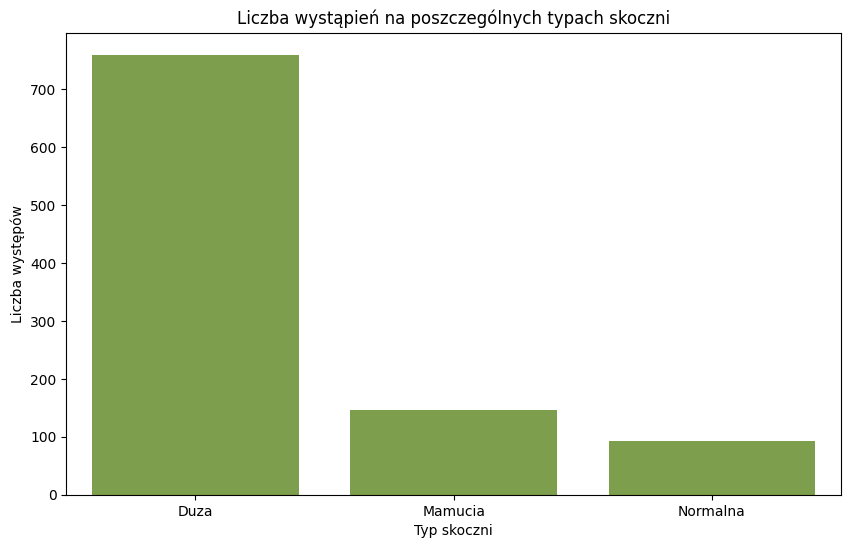

In [40]:
plt.figure(figsize=(10, 6))

sns.countplot(data=df, x='Skocznia', color='#80AB3F', order = df['Skocznia'].value_counts().index)
plt.ylabel('Liczba występów')
plt.xlabel('Typ skoczni')
plt.title('Liczba wystąpień na poszczególnych typach skoczni')

plt.show()

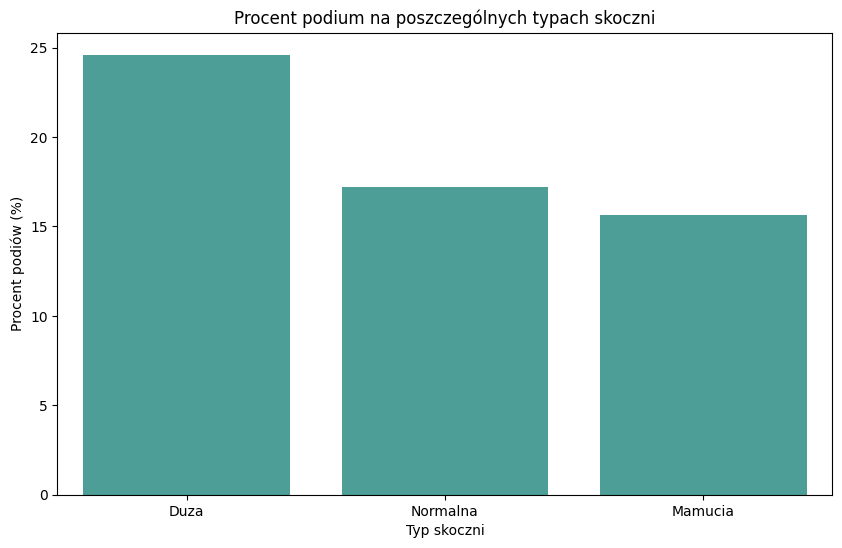

In [41]:
podium_stats = df.groupby('Skocznia')['Wynik'].apply(lambda x: ((x <= 3) & (x > 0)).mean() * 100).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=podium_stats.index, y=podium_stats.values, color='#3FABA1')

plt.title('Procent podium na poszczególnych typach skoczni')
plt.ylabel('Procent podiów (%)')
plt.xlabel('Typ skoczni')

plt.show()

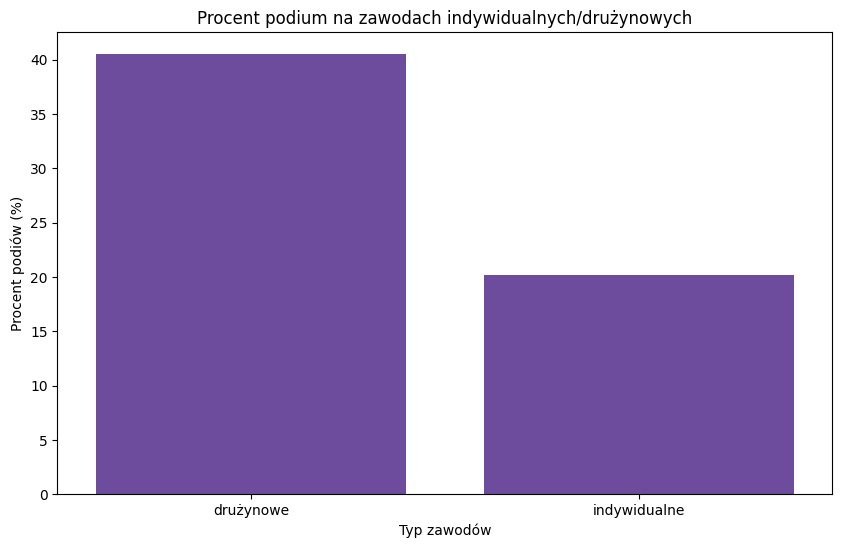

In [42]:
podium_stats = df.groupby('Kategoria')['Wynik'].apply(lambda x: ((x <= 3) & (x > 0)).mean() * 100).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=podium_stats.index, y=podium_stats.values, color='#6A3FAB')

plt.title('Procent podium na zawodach indywidualnych/drużynowych')
plt.ylabel('Procent podiów (%)')
plt.xlabel('Typ zawodów')

plt.show()

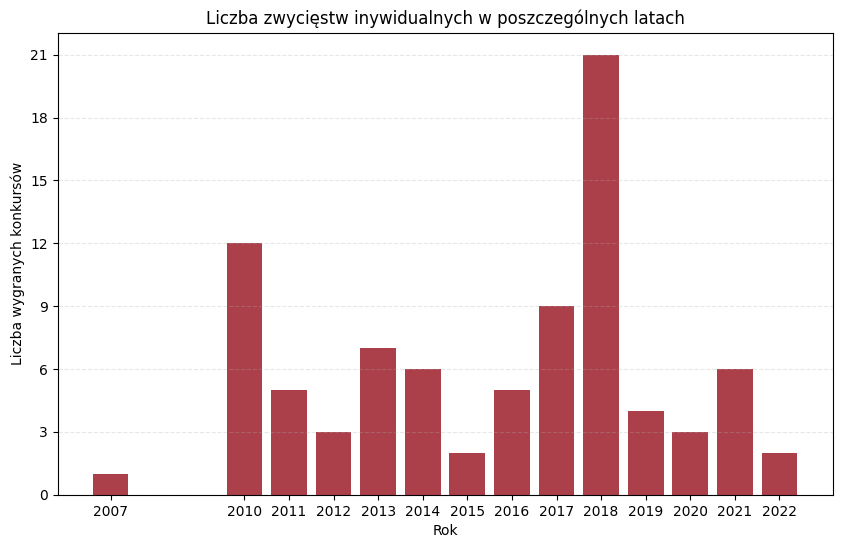

In [50]:
from matplotlib.ticker import MaxNLocator
df['Rok'] = df['Data'].dt.year

zwyciestwa = df[(df['Wynik'] == 1) & (df['Kategoria'] == 'indywidualne')]
zwyciestwa_na_rok = zwyciestwa.groupby('Rok').size()

plt.figure(figsize=(10, 6))

plt.bar(zwyciestwa_na_rok.index, zwyciestwa_na_rok.values, color='#AB3F4A')
plt.title('Liczba zwycięstw inywidualnych w poszczególnych latach')
plt.xlabel('Rok')
plt.ylabel('Liczba wygranych konkursów')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(zwyciestwa_na_rok.index)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()

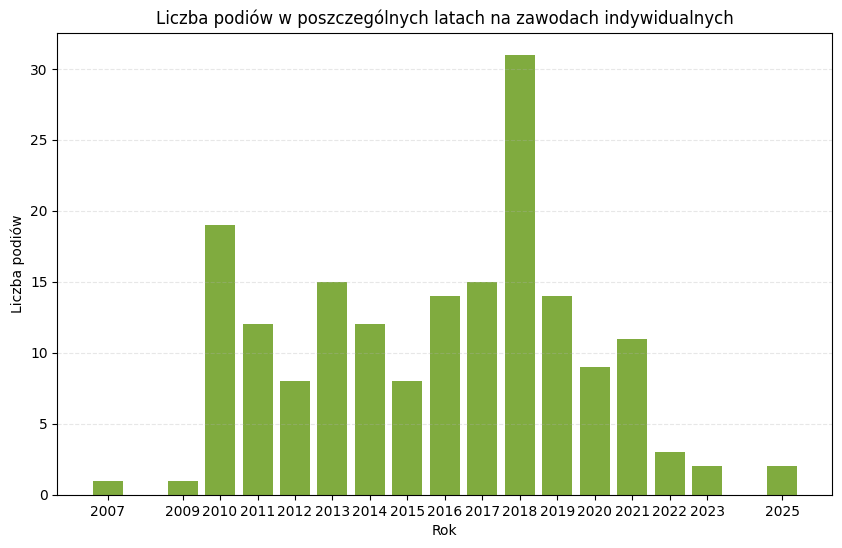

In [49]:
df['Rok'] = df['Data'].dt.year

zwyciestwa = df[(df['Wynik'] >= 1) & (df['Wynik'] <= 3) & (df['Kategoria'] == 'indywidualne')]
zwyciestwa_na_rok = zwyciestwa.groupby('Rok').size()

plt.figure(figsize=(10, 6))

plt.bar(zwyciestwa_na_rok.index, zwyciestwa_na_rok.values, color='#80AB3F')
plt.title('Liczba podiów w poszczególnych latach na zawodach indywidualnych')
plt.xlabel('Rok')
plt.ylabel('Liczba podiów')
plt.xticks(zwyciestwa_na_rok.index)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()

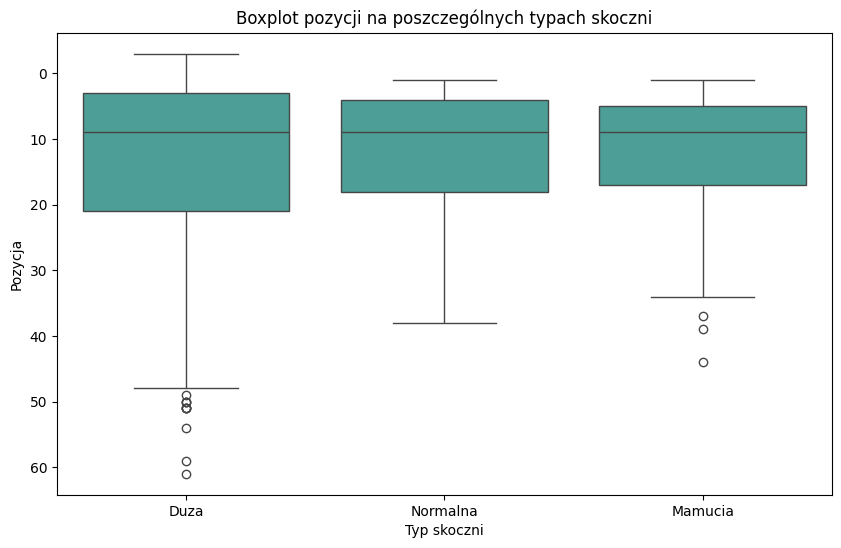

In [45]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Skocznia', y='Wynik', color='#3FABA1')
plt.xlabel('Typ skoczni')
plt.ylabel('Pozycja')
plt.title('Boxplot pozycji na poszczególnych typach skoczni')
plt.gca().invert_yaxis()
plt.show()

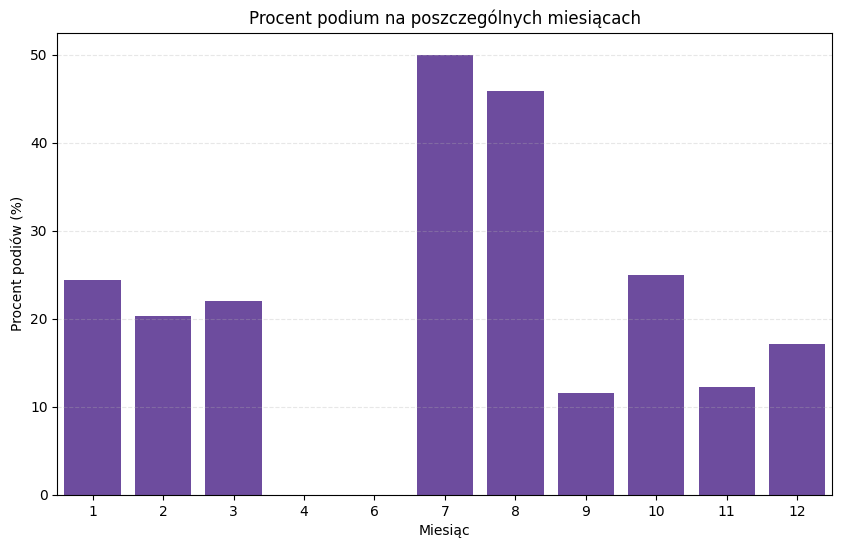

In [51]:
df['miesiac']=df['Data'].dt.month
bestmonth = df.groupby('miesiac')['Wynik'].apply(lambda x: ((x <= 3) & (x > 0)).mean() * 100).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=bestmonth.index, y=bestmonth.values, color='#6A3FAB')
plt.xlabel('Miesiąc')
plt.ylabel('Procent podiów (%)')
plt.title('Procent podium na poszczególnych miesiącach')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()

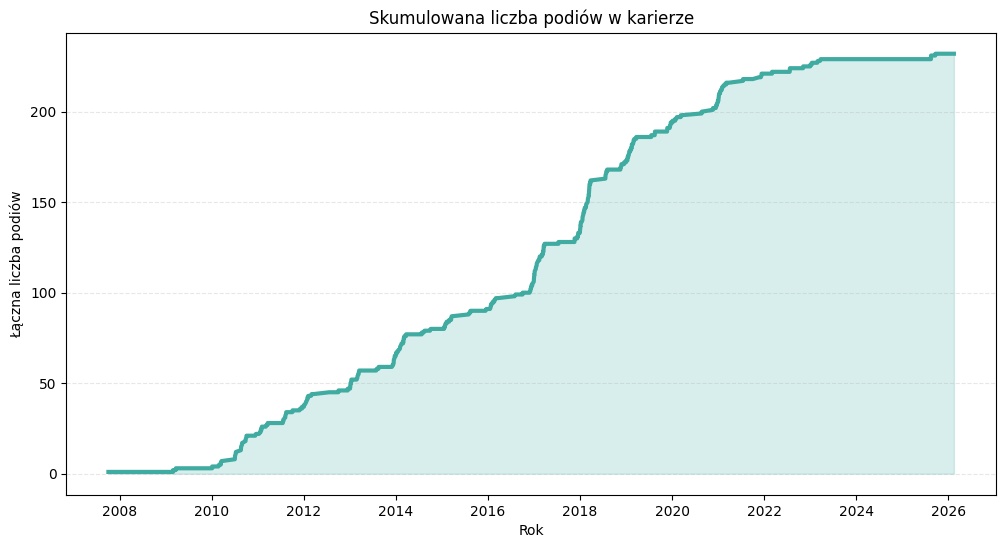

In [52]:
df = df.sort_values('Data')
df['Suma_Podiow'] = (df['Wynik'] <= 3).cumsum()

plt.figure(figsize=(12, 6))
plt.plot(df['Data'], df['Suma_Podiow'], color='#3FABA1', linewidth=3, label='Suma podiów')
plt.fill_between(df['Data'], df['Suma_Podiow'], color='#3FABA1', alpha=0.2)
plt.title('Skumulowana liczba podiów w karierze')
plt.xlabel('Rok')
plt.ylabel('Łączna liczba podiów')
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()